In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt
import os

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [8]:
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [9]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [10]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [12]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

In [13]:
inspector = inspect(engine)
station_columns = inspector.get_columns('station')
measurement_columns = inspector.get_columns('measurement')

In [14]:
for station in station_columns:
    print(station["name"], station["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
for m in measurement_columns:
    print(m["name"], m["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

Text(0.5, 1.0, 'Precipitation in Hawaii 2016-2017')

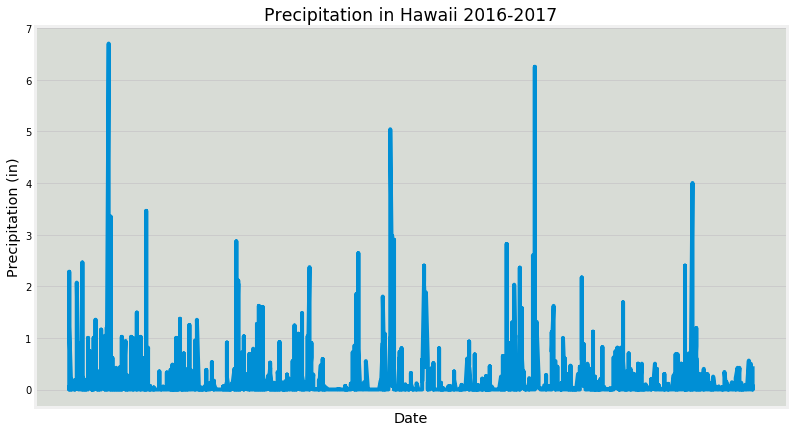

In [55]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
maxdate = session.query(func.max(Measurement.date))
mdsplit = maxdate.scalar().split("-")
prevyear = dt.date(int(mdsplit[0]), int(mdsplit[1]), int(mdsplit[2])) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prevyearmeasurements = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>prevyear)

# Save the query results as a Pandas DataFrame and set the index to the date column
meas_df = pd.read_sql(prevyearmeasurements.statement, engine)

# Sort the dataframe by date
meas_df.set_index("date", inplace=True)
meas_df.sort_index(inplace=True)
meas_df.fillna(0.0,inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data. 
# (Pandas' bulit-in plotting was giving me trouble)
plt.figure(figsize = (12,7))
ax = plt.axes()
ax.set_facecolor("xkcd:light grey")
ax.get_xaxis().set_ticks([])

plt.plot(meas_df.index, meas_df["prcp"])

plt.xlabel("Date", size = "x-large")
plt.ylabel("Precipitation (in)", size = "x-large")
plt.title("Precipitation in Hawaii 2016-2017", size = "xx-large")

![precipitation](Images/precipitation.png)

In [46]:
# Use Pandas to calcualte the summary statistics for the precipitation data
meas_df.describe()

,prcp
count,2223.000000
mean,0.159951
std,0.441220
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


![describe](Images/describe.png)

In [47]:
# Design a query to show how many stations are available in this dataset?
# this seems too easy
total_stations = session.query(Station).count()
total_stations

9

In [53]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc())
for i in most_active_stations:
    print(i)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [63]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
ma_station = most_active_stations[0][0]
print(ma_station)

lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == ma_station)
print(lowest_temp.scalar())

highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == ma_station)
print(highest_temp.scalar())

avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == ma_station)
print(avg_temp.scalar())

USC00519281
54.0
85.0
71.66378066378067


Text(0.5, 1.0, 'Temperature Histogram at Station USC00519281 2016-2017')

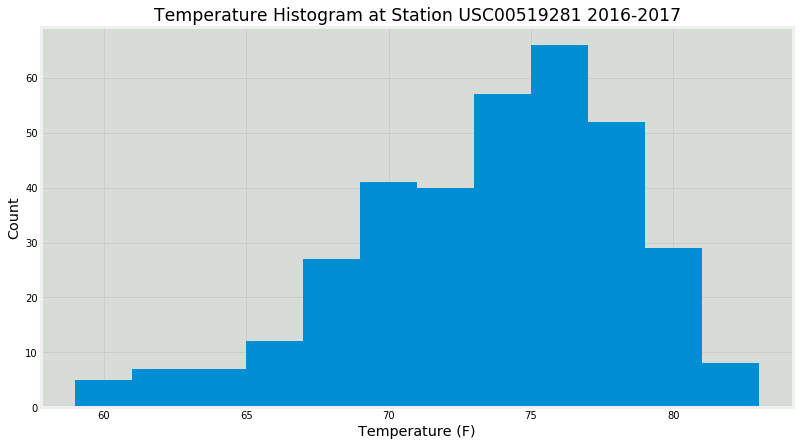

In [79]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a 
# histogram
ma_station_meas_prevyear = session.query(Measurement.tobs).filter(Measurement.station == ma_station, 
                                                                 Measurement.date>prevyear)
ma_station_df = pd.read_sql(ma_station_meas_prevyear.statement, engine)

plt.figure(figsize = (12,7))
ax = plt.axes()
ax.set_facecolor("xkcd:light grey")

plt.hist(ma_station_df["tobs"], bins=12)

plt.xlabel("Temperature (F)", size = "x-large")
plt.ylabel("Count", size = "x-large")
plt.title(f"Temperature Histogram at Station {ma_station} 2016-2017", size = "xx-large")


![precipitation](Images/station-histogram.png)

In [ ]:
# Challenges not attempted
